In [412]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [413]:
import os
import json
import timeit
import collections
from src.Classes import Dataset, Slot, Defence
from src.Enviroment import Environment
from src.Qlearning import QLearning
from src.SARSA import SARSA
from src.RLexperiment import RLExperiment
from src.utils import display_result_schedule

In [414]:
# Przygotowywanie danych o slotach
with open('data/slots/time_slots.json', 'r') as f:
    slots_data = json.load(f)
slots = [Slot(index, time) for index, time in slots_data.items()]

# Przygotowywanie danych o obronach
with open('data/obrony/obrony.json', 'r') as f:
    defences_data = json.load(f)
defences = [Defence(defence_data["student"], defence_data["promotor"], defence_data["recenzent"]) for defence_data in defences_data]

In [415]:
# Przygotowywanie przykładów
examples_folder_path = 'data/examples'
file_names = os.listdir(examples_folder_path)
sorted_file_names = sorted(file_names, key=lambda x: int(x.split('.')[0]))
examples_paths_list = [os.path.join(examples_folder_path, file_name) for file_name in sorted_file_names]


In [416]:
count_list_qlearning = []
count_list_sarsa = []
time_qlearning_list = []
time_sarsa_list = []
schedule_members = []

In [417]:
number_of_episodes = 10000
number_of_examples = 100
full_counter_members_q = collections.Counter([])
full_counter_members_s = collections.Counter([])

In [418]:
for example_path in examples_paths_list[:number_of_examples]:
    dataset = Dataset(example_path)
    chairman = list(dataset.get_chairman_avail().keys())
    chairman_avail = dataset.get_chairman_avail()
    availability = dataset.get_workers_avail()
    members = list(availability.keys())

    # Q-Learning
    q_env = Environment(defences, slots, chairman, members, availability, chairman_avail)
    q_agent = QLearning()

    q_experiment = RLExperiment(q_env, q_agent, num_episodes=number_of_episodes, max_steps_per_episode=30)
    execution_time_q = timeit.timeit(q_experiment.run, number=1)
    time_qlearning_list.append(execution_time_q)

    count_list_qlearning.append(len(q_experiment.schedule))

    schedule_members = []
    for state, action in q_experiment.schedule:
        schedule_members.append(action.member)
    
    counter_members_q = collections.Counter(schedule_members)
    counter_members_q = collections.Counter(counter_members_q.values())
    full_counter_members_q = full_counter_members_q + counter_members_q

    # Zapisywanie do plików

    sorted_data = sorted(q_experiment.get_schedule_json(), key=lambda x: x['numer slotu'])
    with open(os.path.join(example_path, 'qlearning_results.json'), 'w', encoding='utf-8') as outfile:
        json.dump(sorted_data, outfile, indent=1)

    # SARSA
    sarsa_env = Environment(defences, slots, chairman, members, availability, chairman_avail)
    sarsa_agent = SARSA()

    sarsa_experiment = RLExperiment(sarsa_env, sarsa_agent, num_episodes=number_of_episodes, max_steps_per_episode=30)
    execution_time_s= timeit.timeit(sarsa_experiment.run, number=1)
    time_sarsa_list.append(execution_time_s)

    count_list_sarsa.append(len(sarsa_experiment.schedule))

    schedule_members = []
    for state, action in sarsa_experiment.schedule:
        schedule_members.append(action.member)

    counter_members_s = collections.Counter(schedule_members)
    counter_members_s = collections.Counter(counter_members_s.values())
    full_counter_members_s = full_counter_members_s + counter_members_s

    # Zapisywanie do plików

    sorted_data = sorted(sarsa_experiment.get_schedule_json(), key=lambda x: x['numer slotu'])
    with open(os.path.join(example_path, 'sarsa_results.json'), 'w', encoding='utf-8') as outfile:
        json.dump(sorted_data, outfile, indent=1)


In [419]:
print(f'qlerning average time: {sum(time_qlearning_list)/len(time_qlearning_list)}')
print(f'sarsa average time: {sum(time_sarsa_list)/ len(time_sarsa_list)}')

qlerning average time: 0.38716127399999095
sarsa average time: 0.41860990699995454


In [420]:
import matplotlib.pyplot as plt
import numpy as np

def plot_counter_member(counter_list_members_q, counter_list_members_s, number_of_examples_q, number_of_examples_s, number_of_episodes):

    sorted_counter_list_q = counter_list_members_q.most_common()
    sorted_counter_list_s = counter_list_members_s.most_common()

    keys_q = [item[0] for item in sorted(sorted_counter_list_q)]
    values_q = [item[1]/number_of_examples_q for item in sorted(sorted_counter_list_q)]
    keys_s = [item[0] for item in sorted(sorted_counter_list_s)]
    values_s = [item[1]/number_of_examples_s for item in sorted(sorted_counter_list_s)]

    x_coords_q = np.arange(len(keys_q))
    x_coords_s = np.arange(len(keys_s))

    plt.subplot(1, 2, 1)
    plt.bar(x_coords_q, values_q, width=0.4)
    plt.xticks(x_coords_q, keys_q)
    plt.title(f"Qlearning")
    plt.xlabel("Number of appearances of a single person")
    plt.ylabel("Percent of member frequency in schedul")
    for i, v in enumerate(values_q):
        plt.text(i, v + 0.003, str(round(100*v, 2))+'%', ha = "center", weight = "bold", size = 10, rotation=15)

    plt.subplot(1, 2, 2)
    plt.bar(x_coords_s, values_s, width=0.4)
    plt.xticks(x_coords_s, keys_s)
    plt.title(f"SARSA")
    plt.xlabel("Number of appearances of a single person")
    plt.ylabel("Percent of member frequency in schedul")
    for i, v in enumerate(values_s):
        plt.text(i, v + 0.003, str(round(100*v, 2))+'%', ha = "center", weight = "bold", size = 10, rotation=15)

    plt.tight_layout()

    plt.savefig(f'Plots/Members_frequency_{number_of_episodes}_episodes')

    plt.show()

In [421]:
import matplotlib.pyplot as plt
import numpy as np

def plot_counter(counter_list_qlearning, counter_list_sarsa, number_of_examples, number_of_episodes):

    sorted_counter_list_q = counter_list_qlearning.most_common()
    sorted_counter_list_s = counter_list_sarsa.most_common()

    keys_q = [item[0] for item in sorted(sorted_counter_list_q)]
    values_q = [item[1]/number_of_examples for item in sorted(sorted_counter_list_q)]
    keys_s = [item[0] for item in sorted(sorted_counter_list_s)]
    values_s = [item[1]/number_of_examples for item in sorted(sorted_counter_list_s)]

    x_coords_q = np.arange(len(keys_q))
    x_coords_s = np.arange(len(keys_s))

    plt.subplot(1, 2, 1)
    plt.bar(x_coords_q, values_q, width=0.4)
    plt.xticks(x_coords_q, keys_q)
    plt.title(f"Q-learning")
    plt.xlabel("Number of filled slots")
    plt.ylabel("percentage")
    for i, v in enumerate(values_q):
        plt.text(i, v + 0.003, str(round(100*v, 2))+'%', ha = "center", weight = "bold", size = 10, rotation=15)

    plt.subplot(1, 2, 2)
    plt.bar(x_coords_s, values_s, width=0.4)
    plt.xticks(x_coords_s, keys_s)
    plt.title(f"SARSA")
    plt.xlabel("Number of filled slots")
    plt.ylabel("percentage")
    for i, v in enumerate(values_s):
        plt.text(i, v + 0.003, str(round(100*v, 2))+'%', ha = "center", weight = "bold", size = 10, rotation=15)

    plt.tight_layout()

    plt.savefig(f'Plots/Schedule_filled_slots_{number_of_episodes}_episodes')

    plt.show()

In [422]:
import collections

counter_qlearning = collections.Counter(count_list_qlearning)
counter_sarsa = collections.Counter(count_list_sarsa)

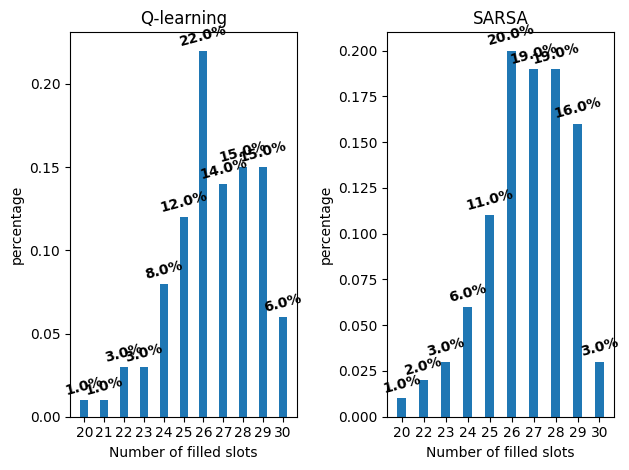

In [423]:
plot_counter(counter_qlearning, counter_sarsa, number_of_examples, number_of_episodes)

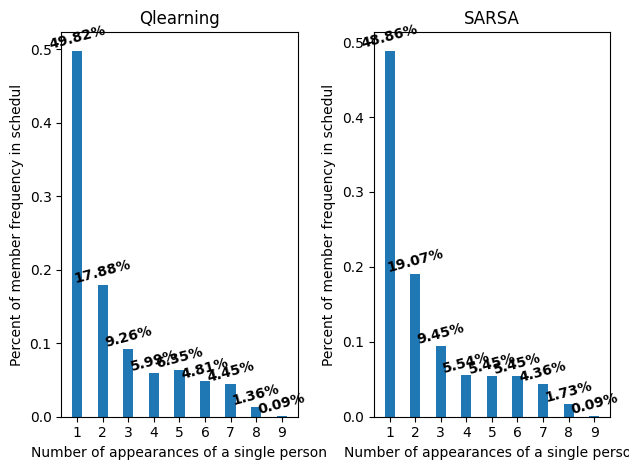

In [424]:
size_q = sum(full_counter_members_q.values())
size_s = sum(full_counter_members_s.values())
plot_counter_member(full_counter_members_q, full_counter_members_s, size_q, size_s, number_of_episodes)